In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import os 

import seaborn as sns; sns.set()

import unsupervised_helper
%aimport unsupervised_helper

vp = unsupervised_helper.VanderPlas()


In [4]:
# Create files containing charts
create = False

if create:
    pca_h = unsupervised_helper.PCA_Helper(visible=False)
    file_map = pca_h.pca_charts()
    print(file_map)

# Unsupervised Learning

- No targets
- Why use it ?
    - Understand your features
    - Better use of features in supervised models

# Plan
- Principal Components
    - Highly popular model for dimensionality reduction
- Clustering
    - K-means to cluster samples
    - Hierarchical clustering
- Recommender systems
    - Netflix prize
    - Pseudo SVD

# Alternate basis

We can find an *alternate* set of $n$ basis vectors of length $n$
$$
\tilde\v_{(1)}, \ldots, \tilde\v_{(n)}
$$
and translate $\x^\ip$ into coordinates $\tilde\x^\ip$ in the alternate basis


$$
\tilde\x^\ip = \sum_{j=1}^n { \tilde\x^\ip_j * \tilde\v_{(j)} }
$$

*Principal Components Analysis (PCA)* is a method for finding an alternate basis $
\tilde\v_{(1)}, \ldots, \tilde\v_{(n)}
$
- $\tilde\v_{(j)}$ is called *Principal Component $j$*
- That are mutually orthogonal
$$
\tilde\v_{(j)} \cdot \tilde\v_{(j')} = 0, \text{for } j \ne j'
$$
- $\tilde{\v}_{(j)}$ has more variation than $\tilde{\v}_{(j')}$ for $j \lt j'$

The number of basis vectors in the original and alternate bases is both $n$.

Suppose we reduced the number of alternate basis vectors to $r \le n$.
- We set $\tilde\x^\ip_j = 0$ for $j \gt r$

This is the *reduced dimension* approximation of $\x^\ip$.

$$
\tilde \x^\ip = \sum_{j=1}^r { \tilde\x^\ip_j * \tilde\v_{(j)} }
$$



Since the basis vectors are ordered such that $\tilde\v_{(j)}$
captures more variation than $\tilde\v_{(j')}$ for $j \lt j'$
- Dropping the alternate bases of higher index loss minimal information

PCA is the process of
- Finding alternate bases $\tilde\v$
- The alternate bases capture correlation among original features $\x$
- Projecting $\x^\ip$ onto the alternate basis $\tilde\v$ to obtain transformed vector $\tilde\x^\ip$ of synthetic features
- Choosing an $r$ so that $\tilde\x^\ip$ is of dimension $r \le n$


<img src="images/Back_to_parent.jpg">

# What is PCA

- A way to achieve dimensionality reduction
- Through the interdependence of features


As we mentioned: one use of dimensionality reduction is to find clusters of examples.
- One important difference from other methods for finding clusters
- The Decision Tree associates a cluster of examples with each node of the tree
- But the process of defining the clusters is guided by the **targets**
- Which are not present in Unsupervised Learning.




# PCA: High Level

<div class="alert alert-block alert-warning">
    <b>TL;DR</b> 
    <br>
    <ul>
        <li>PCA is a technique for creating "synthetic features" from the original set of features</li>
        <li>The synthetic features may better reveal relationships among original features</li>
        <li>May be able to use reduced set of synthetic features (dimensionality reduction)</li>
        <li>Synthetic features as a means of clustering samples</li>
        <li><strong>All features need (and will be assumed to be) centered: zero mean</strong></li>
        <li>PCA is <strong>very scale sensitive</strong>; often normalize each feature to put on same scale</li>
        </div>


The key ideas behind PCA:
- Synthetic features are more like "concepts" than simple attributes
    - Commonality of purpose rather than surface similarity
    - e.g., the "factors" in the equity factor model example
- The synthetic features are mutually *independent* (uncorrelated)
- A transformation of examples from a basis of original features to a basis of synthetic features
- Order of "importance" of synthetic features
    - Facilitates dimensionality reduction by dropping "less important" features


**Preview**

In one picture:

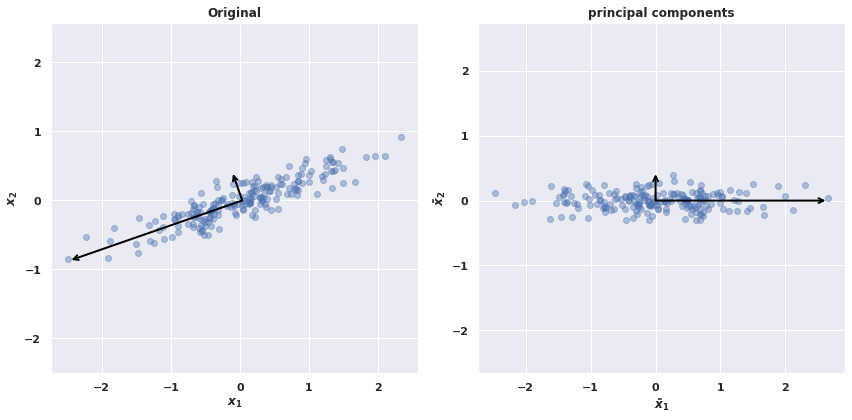

In [5]:
X = vp.create_data()

vp.show_2D(X)

The points in the left and right plots are the same, except for the coordinate system.
- Left plot: coordinate system is the horizontal and vertical axes, as usual
    - Features $\x_1, \x_2$
- Right plot: coordinate system changed
    - So that the arrowed lines of the left plot
    - Become the horizontal and vertical axes of the right plot (rotate and flip)
    - Features $\tx_1, \tx_2$


In the left plot, we can clearly see that the data set's features $\x_1, \x_2$ are correlated.

In the right plot: $\tx_1, \tx_2$ are
- Independent
- With $\tx_1$ expressed greater variation

**Note**

- The long arrowed line in the left plot
- Moves in the negative direction
- And is "flipped" to move in the positive direction of the right plot
- So the examples are the same, but rotated and flipped
    - We can more clearly see that in the examples highlighted in red

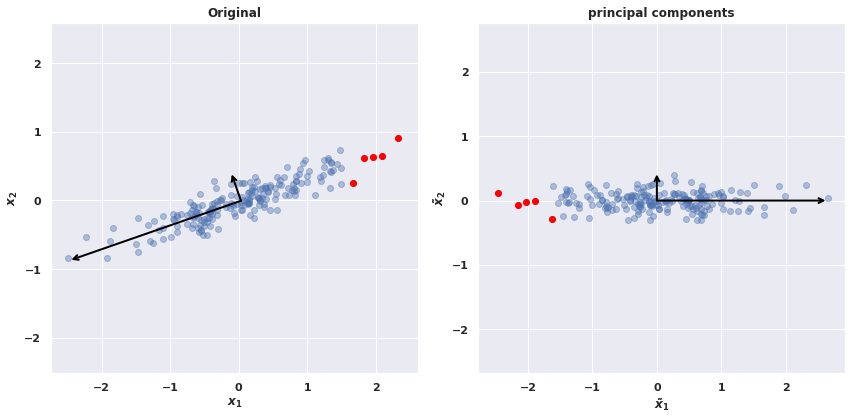

In [6]:
vp.show_2D(X, points=X[ X[:,0] > 1.5 ])

We can use matrix notation to summarize the process
$$
\X = \tilde \X V^T
$$

- The examples $\X$, expressed in the original basis
- Are the same as the examples
    - Expressed in alternate basis defined by $V$
    - With new feature values $\tilde\X$
    - When the number of new basis vectors is $n$, the number of original basis vectors

That is
- Examples $\x^\ip$ becomes $\tilde\x^\ip$
    

<img src="images/Back_to_parent.jpg">

# PCA via Matrix factorization

Our objective in this section is to show how to obtain $\tilde\X$ and $V$ such that
$$
\X = \tilde\X V^T
$$

Decomposing $\X$ into a product (as above) is called *matrix factorization*

Some types of matrix factorization we'll mention
- Singular Value Decomposition
- Eigen Decomposition
- CUR Decomposition

**Important note**

We will assume that
$\X$ has been **zero centered**: each feature value has had the mean  value of the feature (across all examples) subtracted

## Singular Value Decomposition (SVD) Factorization

Our goal is to find 
- a new set of basis vectors $\V$
- a way of expressing $\X$ in terms of $\V$
    - via loadings $\tilde \X$
    
$$
\X = \tilde \X \V^T
$$

We can view this expression as a factorization of matrix $\X$.


One method for factoring $\X$ is called *Singular Value Decomposition (SVD)*.

Matrix $X$ is factored into the product of 3 matrices:
$$
\X = U \Sigma V^T
$$
- $U$: $m \times n$, columns are orthogonal unit vectors
    - $U U^T = I$
- $\Sigma: n \times n$ diagonal matrix 
$$
\text{diag}(\Sigma) = [ \sigma_1, \sigma_2, \ldots, \sigma_n ]
$$
- $V: n \times n$, columns are orthogonal unit vectors
    - $V V^T = I$
    
Moreover, the diagonal elements of $\Sigma$ are in descending order of magnitude
$$
\sigma_j > \sigma_{j'} \; \text{ for } j \lt j'
$$

Given the SVD factorization of $\X$
$$
\X = U \Sigma V^T
$$
let us define $\tilde\X$ as
$$
U \Sigma 
$$

so that
$$
\X = \tilde \X \V^T
$$

as required.

The definition of $\tilde\X = U \Sigma$ leads to an interesting interpretation of $U$.
- since $\Sigma$ is a diagonal matrix
- the product $U \Sigma$
    - scales the columns of $U$ by the diagonal elements of $\Sigma$
$$
\tilde\X^\ip = (U^\ip_1 * \sigma_1, U^\ip_2 *\sigma_2, \ldots, U^\ip_n * \sigma_n)
$$

by definition of matrix multiplication and the fact that all elements of column $j$ of $\Sigma$ are $0$ except
for row $j$.



Thus  
- $U$ can be thought of as a "standardized" version of features $\tilde\X$
    - Unit standard deviation
- $\tilde\X = U \Sigma$ is the non-standardized features

A picture may clarify the distinction between the standardized and non-standardized $\tilde\X$.

Here is the non-standardized $\tilde\X$ that we've seen previously

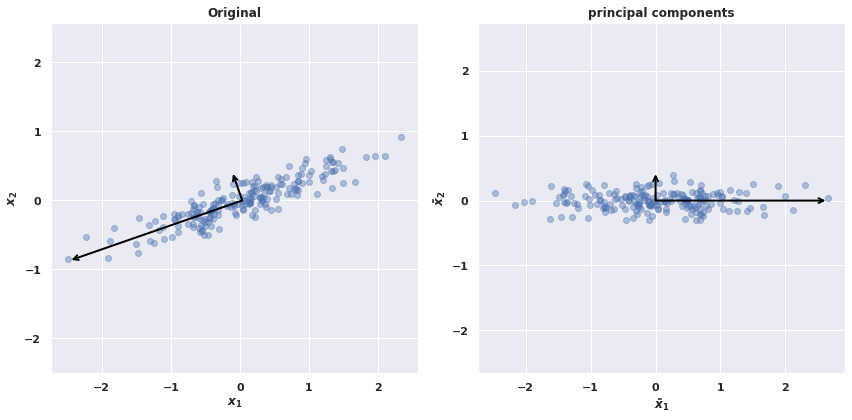

In [7]:
X = vp.create_data()

vp.show_2D(X)

And here is the standardized plot of $U$
- The length of each basis vector is $1$
- Rather than $\sigma_j$
- By stretching each component by $\sigma_j$ we recover the non-standardized plot

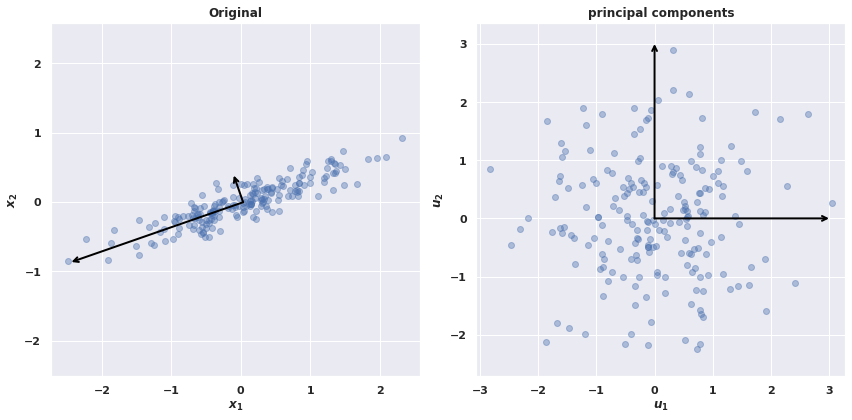

In [8]:
vp.show_2D(X, whiten=True)


- We can see that, in the standardized coordinates: the feature values are cloud-like, independent
- The magnitude of the diagonal elements $\sigma_i$
    - Is related to the variation (how far the spread) of
non-standardized synthetic feature $i$
    - Which we will associate with the "importance" of the non-standardized feature

<img src="images/Back_to_parent.jpg">

## The new basis ("components") $\V$

It may be easier (for some) to view the matrix multiplication
$$
\X = \tilde \X \V^T
$$
as a simple sum and product.

We can do this by examining one row $\X^\ip$.

$$
\begin{array} \\
\X & = & \tilde\X \V^T & \text{factorization of }  \X\\
\X^\ip & = & \tilde\X^\ip \V^T & \text{one row of the matrix multiplication } \\
& = & \sum_{j=1}^n { \tilde\X^\ip_j * \v^{(j)} } &  \text{definition of matrix multiplication by a row vector} \\
& & & \text{where } \v^{(j)}: (1 \times n) \text{ is row } j \text{ of } \V^T \\
& & & \tilde\X^\ip_j \text{ scales row } j \text{ of } \V^T \\
& = & \sum_{j=1}^n { \tilde\X^\ip_j * \V_j } &  \v^{(j)} = \V_j \, (\text{column } j \text{ of } V )\\
\end{array}
$$

Thus
$$
\X^\ip = \sum_{j=1}^n { \tilde\X^\ip_j * \V_j }
$$
- the columns of $\V$ are the new basis vectors
- called the *components*
    - hence Principal Compoments
- with loadings $\tilde\X^\ip$


## Dimensionality reduction

Thus far we have exactly replicated $\X$ via new bases $V^T$
$$
\X = \tilde\X V^T
$$

$\tilde\X$ is the same dimensions as $\X$, so each example is of length $n$ in both
the original and alternate representation.

We will now change $\tilde\X$ to $(m \times r)$ for $r \le n$.

That is: the alternate representation may be of reduced dimension.

Recall that
$$
\begin{array}[lll]\\
\tilde\X^\ip & = & (U \Sigma)^\ip \\
 & = & U^\ip * \text{diag}(\Sigma) \\
& = & [  U^\ip_1 * \sigma_1, U^\ip_2 * \sigma_2, \ldots, U^\ip_n * \sigma_n ] \\
\end{array}
$$

By setting
$$
\sigma_j = 0, \; \text{for all } j \gt r
$$

we zero out all features with index exceeding $r$
$$
\begin{array}[lll]\\
{\tilde{\X}}'^\ip & = & (U \Sigma)^\ip \\
& = & [  U^\ip_1 * \sigma_1, U^\ip_2 * \sigma_2, \ldots, U^\ip_r * \sigma_r, \mathbf{0,  \dots 0}] \\
\end{array}
$$

The dimensions of ${\tilde{\X}}'^\ip$ is effectively reduced from $n$ to $r \le n$.


Zeroing out the diagonal elements of $\Sigma$ with index $j \gt r$ makes the values in
- The columns of $U$ with index $j \gt r$
- The rows of $(V^T)$ with index $j \gt r$

irrelevant.

We can therefore write
$$
\X' \approx \X
$$
where
$$
\begin{array}[lll]\\
\X' = U' \Sigma' (V^T)' \\
\end{array}
$$
where
- $\X'$ is $(m \times n )$
- $U'$ is $(m \times r)$
- $\Sigma'$ is $(r \times r)$
- $(V^T)'$ is $(r \times n)$

$\X$ and $\X'$ have the *same* dimensions, but the values in $\X'$ can only *approximate* the values in $\X$.

The advantage is that ${\tilde\X}'$ is of lower dimension.

## Best lower rank approximation of $\X$

We could have reduced the dimension of ${\tilde\X}'$ by dropping *any* set  of $(n-r)$ columns.

Let $D$ denote the set of size $(n-r)$ containing the indexes of the columns we choose to drop.

Is there a particular reason for dropping the columns
$$
D = \{ j \, | \, j \gt r \}
$$

To answer the question, we first define the *error* of the approximation $\X'$ relative to the
true $\X$
$$
{|| \X' - \X ||}_2 =  \sum\limits_{i,j}{ \left( {\X'}^\ip_{j} - \X^\ip_{j}\right)^2 }
$$

The above is called the Froebenius Norm (and looks like MSE in form).

The "best" set of columns to drop (from $\Sigma$) are the one resulting in the *lowest* error.


Recall that 
$$
\begin{array}[lll]\\
\tilde\X^\ip 
& = & [  U^\ip_1 * \sigma_1, U^\ip_2 * \sigma_2, \ldots, U^\ip_n * \sigma_n ] \\
\end{array}
$$

and
$$
\X^\ip  = \tilde\X^\ip V^T
$$

So 
$$
\begin{array}[lll]\\
\X^\ip_j & = & [  U^\ip_1 * \sigma_1, U^\ip_2 * \sigma_2, \ldots, U^\ip_n * \sigma_n ] \cdot (V^T)_j & \text{ where } (V^T)_j \text{ is column } j \text{ of } V^T \\
 & = & \sum_{k=1}^n { U^\ip_k * \sigma_k * (V^T)_j^{(k)}} & \text{multiply row } i \text{ of U} \text{ by column } j \text{ of } V^T \text{(def. of matrix multiplication)} \\
 & = & \sum_{k=1}^n {   \sigma_k * (U^\ip_k * (V^T)_j^{(k)}) } \\
\end{array}
$$

The approximation error in $\X^\ip_j$ induced by dropping the columns in $D$ is
$$
\begin{array}\\
(\X^\ip_j - \X'^\ip_j)^2 & = &  \left( \sum_{k \in D} {   \sigma_k * (U^\ip_k * (V^T)_j^{(k)}) } \right)^2 \\
\end{array}
$$

Because the diagonal elements of $\Sigma$ are in decreasing order of magnitude
$$
\sigma_j > \sigma_{j'} \; \text{ for } j \lt j'
$$


choosing $D$ to be
$$
D = \{ j \, |\, j \gt r \}
$$
results in dropping terms $U^\ip_k * (V^T)_j^{(k)}$ that are scaled by the $(n-r)$ *smallest*   values o$\sigma_k$.

Although this is not mathematically precise, hopefully this provides some intuition as to why
choosing $D$ this way is a good idea.

**Aside**

It will
turn out that
$$
\begin{array}[lll]\\
& & \left( \sum_{k \in D} {   \sigma_k * (U^\ip_k * (V^T)_j^{(k)}) } \right)^2 \\
& = & \sum_{k \in D} { \sigma_k^2 } \\
\end{array}
$$
which makes the intuitive argument precise.


## How many dimensions to keep ?

Since the diagonal elements of $\Sigma$ are ordered
- We can compute a cumulative, normalized sum $s$ of $\sigma^2$
    $$s_j = \frac{\sum_{j' =1}^j \sigma_{j'}^2}{\sum_{j' =1}^n \sigma_{j'}^2}$$
- Such that
$$s_n = 1$$
- So that $s_j$ is the *fraction* of total variance associated with the first $j$ components

We can then chose the number $r \le n$ of reduced dimensions
- As the $r$ such that $s_r \ge T$
- Where $T$ is a threshold fraction for explained variance
- For example
$$T = 95\%$$

A detailed example of PCA performed on the MNIST digits follows in a later section.

The cumulative variance, as a function of number of features kept, looks like:


<table>
    <tr>
        <center><strong>PCA: MNIST digits, cumulative variance</strong></center>
    </tr>
<img src=images/cum_var.png>
</table>

From the chart: we can capture 95% of the cumulative variance using roughly 150 synthetic features.

<img src="images/Back_to_parent.jpg">

# The inverse transformation

We have shown how to transform original features $\X$ to synthetic features $\tilde\X$.

How about inverting the transformation: recover $\X$ from $\tilde\X$ ?

Since
$$
\begin{array}[lll]\\
\X & = & \tilde\X V^T & \text{definition} \\
\X V & = & \tilde\X V^T V & \text{multiply both sides by } V \\
\X V & = & \tilde\X & \text{since } V^T V = I \\
\end{array}
$$


So 
- $V$ transforms from original features $\X$ to synthetic feature $\tilde\X$
- $V^T$ transforms synthetic features $\tilde\X$ to original features $\X$


<img src="images/Back_to_parent.jpg">

# PCA in `sklearn`

Principal Components Analysis is a *transformation* in `sklearn`

As with all transformations in `sklearn`
- it must be *fit* with the training data
- once fit, the transformation may be *applied*
    - to the features of the training data, and used to train a model, e.g., a Classifier
    - to out of sample examples, to make predictions
    

Relating this to our terminology:
- fit to the training data     
    - This computes $U, \Sigma, V$)
    - These computed values are used to transform examples

- transform examples
    - training data $\X$ to reduced dimension alternate basis:  $\tilde \X'$
    - out of sample test example $\x_\text{test}$ to reduced dimension alternate basis: $\tilde \x'_\text{test}$
- Use the transformed examples, e.g., to build and evaluate the predictive model
    -  e.g., use the transformed training data as input to a predictive model `model`
    - e.g.,  use the transformed text examples to evaluate Performance Metric on predictive model `model`
    
Here is some pseudo-code to illustrate

    # Split example <X, y> into training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Instantiate the PCA object: reduce dimension from X.shape[-1] to n_components
    pca = PCA(n_components=n_components)
     
    # Fit PCA to training examples
    pca.fit(X_train)
    
    # Transform the training examples
    X_tilde = pca.transform(X_train)
    
    # Use the transformed training examples to fit a model for prediction
    model = ...
    model.fit(X_tilde, y_train)
    
    # Transform the test examples
    X_test_tilde = pca.transform(X_test)
    
    # Use the transformed test examples in the model to get predicted results
    y_test_pred = model.predict(X_test_tilde)
    
    accuracy_score(y_test, y_test_pred)
    

# Example: Reconstructing $\x$ from $\tilde\x$ and the principal components

Our original examples $\X$ can be approximated
- with reduced dimensionality $r \lt n$
- with loadings $\tilde \X$ on $\V^T$
$$
\X \approx \tilde \X \V^T
$$
where
\begin{array} \\
\X & : & (m \times n) \\
\tilde \X & : & (m \times r) \\
\V^T & : &(r \times n) \\
\end{array}

The approximation becomes equality only when $r = n$ (no dimensionality reduction)





Using a single example $\x \in \X$
- with corresponding reduced dimensionality representation $\tilde \x$
- we will vary $r$
- in order to demonstrate
    - the increased quality of reconstruction as $r$ increases

We will also visualize the principal components
- in an attempt to interpret them

Our examples will be $(8 \times 8)$ pixel grids
- representing a subset of the digits:
$$\{ 0, 4, 7, 9 \}$$
- $n = 64$
- we choose $r = 8$

We choose a subset to aid the visualization.

In [9]:
subset1 = [ 0, 4, 7, 9 ]
rh_digits = unsupervised_helper.Reconstruct_Helper( subset=[])
rh_digits.create_data_digits(subset=subset1)

In [10]:
n_components = 8
_= rh_digits.fit(n_components=n_components)

In [11]:
# Which example to show
data_idx = 0
fig0, ax0, figm, axm, figc, axc = rh_digits.show_data_comp(data_idx=data_idx)

plt.close(fig0)
plt.close(figm)
plt.close(figc)

Here is one example $\x \in \X$

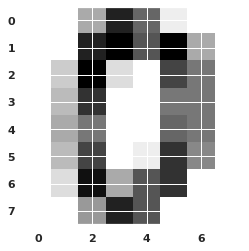

In [12]:
fig0

Recall
- The examples used in PCA should be **zero-mean**
- We apply a transformation to $\X$ to transform each feature to mean $0$
- When reconstructing $\x$ from $\tilde \x$
    - we will have to *add back* the mean

Here is the mean of $\X$

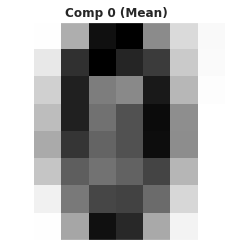

In [13]:
figm

And here are the Principal Components (new bases)
- the rows of $\V^T$
    - $\V^T: (r \times n)$
    - $r$ components, each of length $n$

visualized as $(8 \times 8)$ pixel grids

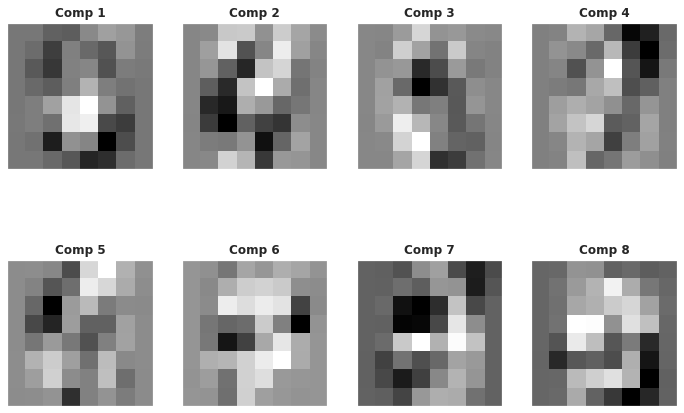

In [14]:
figc

It's not necessarily easy to interpret the components, particularly when $n$ is large
- by considering a small subset of the digits, we have aided the interpretation

By visual inspection
- Component 1 *might* be the "concept" corresponding to the digit 0
- Component 4 *might* be the "concept" corresponding to the digit 4
- The other components *might* be *partial* shape concept, rather than entire digits

Let's progressively examine the approximation of $\x$ using an increasing $r$ (number of synthetic features)
$$
\x^\ip = \sum_{j=1}^r { \tilde\x^\ip_j * (V^T)^{(j)} }
$$


So we construct an approximation of $\x^\ip$
- By adding weighted components $(V^T)^{(j)}$, each of length $n$
- The weight associated with component $j$ is $\tilde\x^\ip_j$
- So the sum is of length $n$

Recall
- $\x^\ip$ has been transformed to be *zero-mean*
- we will visualize the approximation of $\x$
    - by *adding back the mean*
    - modifying the summation
        - with element $0$
        - having loading $1$
        - on the mean $\X$

In [15]:
figi, axsi, fig_comp, axs_comp, x_tilde, error = rh_digits.show_recon(data_idx=data_idx)
plt.close(figi)
plt.close(fig_comp)

Here is a comparison of the original $\x^\ip$ and its reconstructed approximation
- using all components

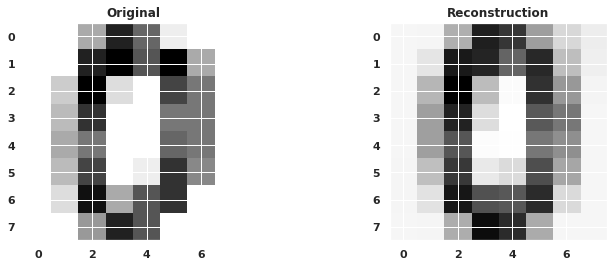

In [16]:
fig_comp

Looks pretty good !
- the approximation via reduced dimension $*$
- does not seem to have lost much information

And here is the reconstruction
- as we vary $r$

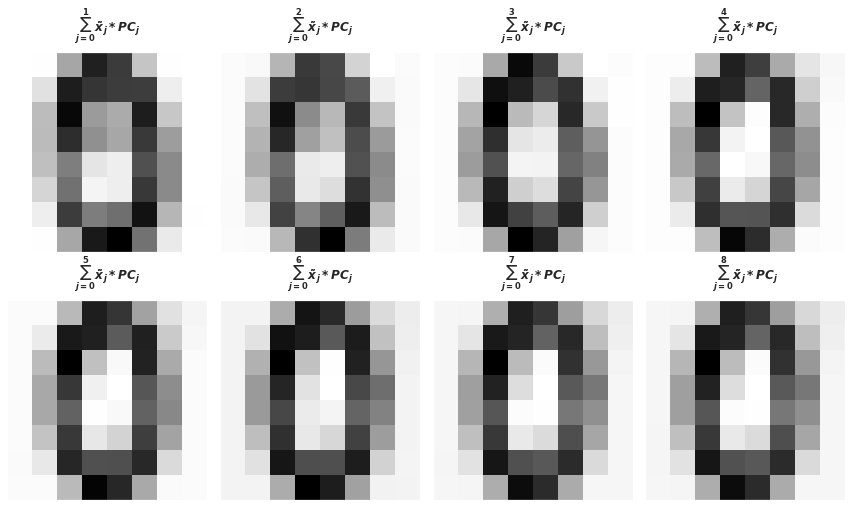

In [17]:
figi

You can see that the approximation using just the first component (and the mean)
- Is already a good approximation of $\x^\ip$
- Somewhat confirming our *guess* that component 1 represents the concept $0$

This is not surprising since both $\x$ and the first component are instances of the concept $0$.

You are encourage to play with the code
- to view the approximation of other examples from $\X$ that don't depict $0$

One objective is to demonstrate how we can try to interpret the components.

We don't have to count on the ability to visualize.

An alternative:
- looking at $\tilde\x^\ip$ numerically:

In [18]:
print("x tilde = ", x_tilde)

arg_max = np.argmax(x_tilde)
print("Largest feature at index {idx:d}".format(idx=arg_max+1))

x tilde =  [ 18.94186808   5.0955433  -11.11741053   6.39696282  -0.96109429
   3.23717355   2.54098823   0.07489345]
Largest feature at index 1


As you can see, the magnitude of $\tilde\x^\ip_1$ is the largest among $[ \tilde\x^\ip_j \, | \, 1 \le j \le r ]$

It makes sense that an example $0$ would have high loading on the concept $0$.

We might try to confirm our interpretation of the first component as the concept $0$
- by examining the loading on the first component
- of *other* examples in $\X$ that correspond to the digit $0$
    - By examining $\tilde\x^{(i')}$ for all $i'$ where $\y^{(i')} = 0$ (assuming we have targets/labels)

In [19]:
# Get X tilde and the targets
Xtilde = rh_digits.dataProj
y = rh_digits.targets

# Filter to identify examples where target is equal to digit
digit = 0
mask = (y == digit)
Xtilde_digit = Xtilde[mask]

In [20]:
print("x tilde, when y=0:")

for i in range(0,10):
    print( [ "{x:3.2f}".format(x=x_tilde_j) for x_tilde_j in Xtilde_digit[i] ])

x tilde, when y=0:
['18.94', '5.10', '-11.12', '6.40', '-0.96', '3.24', '2.54', '0.07']
['10.94', '11.59', '-8.82', '8.34', '-6.50', '4.19', '4.22', '-4.46']
['15.16', '8.46', '-9.70', '2.85', '-3.39', '-5.13', '-3.83', '-7.18']
['21.68', '9.93', '-12.65', '3.27', '1.32', '4.84', '-0.87', '-4.07']
['13.36', '8.83', '-11.29', '4.24', '-0.35', '-1.19', '1.00', '-12.08']
['19.57', '7.25', '-9.87', '-3.35', '-1.75', '7.12', '4.04', '0.30']
['20.21', '9.81', '-7.81', '-2.10', '-2.19', '-1.38', '-0.82', '3.76']
['10.75', '12.33', '-9.70', '-1.01', '-4.82', '-7.07', '-4.91', '-12.87']
['17.96', '12.42', '-5.09', '-5.08', '2.47', '-8.20', '-2.89', '-11.09']
['22.48', '1.51', '-7.25', '-10.33', '3.19', '3.60', '0.19', '4.91']


As you can see
- For examples $\x^{(i')}$ where $\y^{(i')} = 0$
- $\tilde\x^{(i')}_1$ is the largest value in $\tilde\x^{(i')}$, for all $i'$ that we examined

We will re-visit the topic of interpreting the components in a little bit.

## Taking advantage of reduced dimensionality

Reducing the dimensionality of examples from $n$ features to $r \lt n$ features has several advantages
- large number of features are hard to manage, both logically and computationally
- collinearity between features may increase as $n$ grows
    - numerical problems for some models: Linear Regression, Logistic Regression
    
Moreover, the new synthetic features $\tilde \x$ are *orthogonal*
- easier to ascribe a contribution of each feature to the target

But a great advantage is that we can plot in 2 and 3 dimensions.

This can be useful for analyzing whether
- examples expressing a common property
- form clusters

Let's plot the examples in our subset of $4$ of the digits
- using just the first $2$ components ($r=2$)

Number of examples: 718


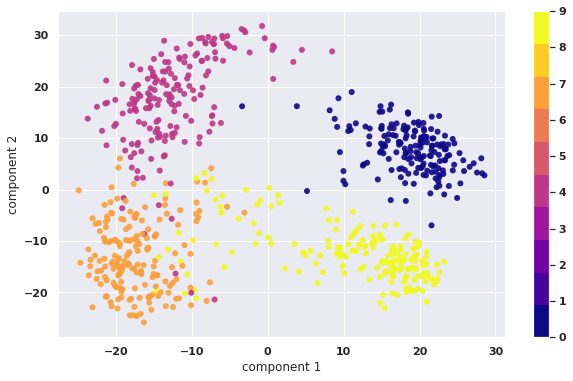

In [21]:
vpt = unsupervised_helper.VanderPlas()

print("Number of examples: {n:d}".format(n=Xtilde.shape[0]))
vpt.digits_subset_show_clustering(Xtilde, y, save_file="/tmp/digits_subset_cluster.jpg" )

We can definitely see clusters in each of the 4 quadrants.

In the absence of colors (i.e., labels associated with each example)
- it would take some effort to determine the property common to each cluster

Fortunately, in this case
- our examples have labels
- which we use to color the points in the plot

We can see that the "common property" of each cluster is the label.

The "common property" might be something **other** than the label.

For example, had we used all 10 digits we might have various hypotheses for the common property
- digits with strong vertical visualization (1, 4, 7, 9)
- open versus closed visualization: 3 versus 8, 7 versus 9



We can purse the interpretation of the components further.

For example, the $0$'s (upper right cluster)
- have high loadings $\tilde \x_1$
- but so do $9$'s (lower right cluster)
- $0$'s differ from $9$'s only in the value of their $\tilde \x_2$
    - does this suggest an interpretation for component $2$ ?
    
Similarly
- $0$'s and $4$'s (upper left cluster)
- have similar $\tilde \x_2$
- but different sign for $\tilde \x_1$
    - does this suggest and interpretation for component $1$ ?



<img src="images/Back_to_parent.jpg">

# Dimensionality reduction:examples

## MNIST example

In our introduction we illustrated representing MNIST digits
- With $r \approx 150$ synthetic features 
- Rather than $n = 28*28 =784$ original features.

Using the techniques illustrate for the "small digit subset" example above, you might
try to interpret the components
- We had argued that "blocks of dark pixels" in each corner was a source of redundancy
    - Was such a concept discovered by PCA ? Is it more subtle ?

This section of code should be a playground for you to experiment and deepen your understanding of PCA.

Here we provide some helper code.

First, retrieve the full MNIST dataset (70K samples)

We had previously used only a fraction in order to make our demo faster.

In [22]:
ush = unsupervised_helper.PCA_Helper()

X_mnist, y_mnist = ush.mnist_init()

Retrieving MNIST_784 from cache


In [23]:
from sklearn.model_selection import train_test_split
X_mnist.shape, y_mnist.shape
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist)
X_mnist_train.shape

((70000, 784), (70000,))

(52500, 784)

Perform PCA.

In [24]:
pca_mnist = ush.mnist_PCA(X_mnist_train)

In [25]:
pca_mnist.n_components_
X_mnist_train_reduced = ush.transform(X_mnist_train, pca_mnist)
X_mnist_train_reduced.shape

154

(52500, 154)

Let's plot the cumulative variance as a function of number of synthetic features.

This can help us determine how many synthetic features to keep.

To capture 95% of variance we need 154 synthetic features.


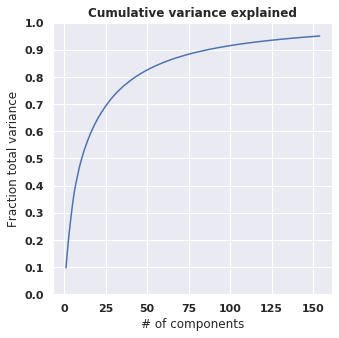

In [26]:
_ = ush.plot_cum_variance(pca_mnist)

variance_goal_pct = 95
features_for_goal = ush.num_components_for_cum_variance(pca_mnist, .01 * variance_goal_pct)
print("To capture {f:d}% of variance we need {d:d} synthetic features.".format(f=variance_goal_pct, d=features_for_goal))


So we need only about 20% of the original 784 features to capture 95% of the variance.

We can invert the PCA transformation to go from synthetic feature space back to original features.

That is, we can see what the digits look like when reconstructed from only 154 synthetic features.

First, let's look at the original:

(52500, 154)

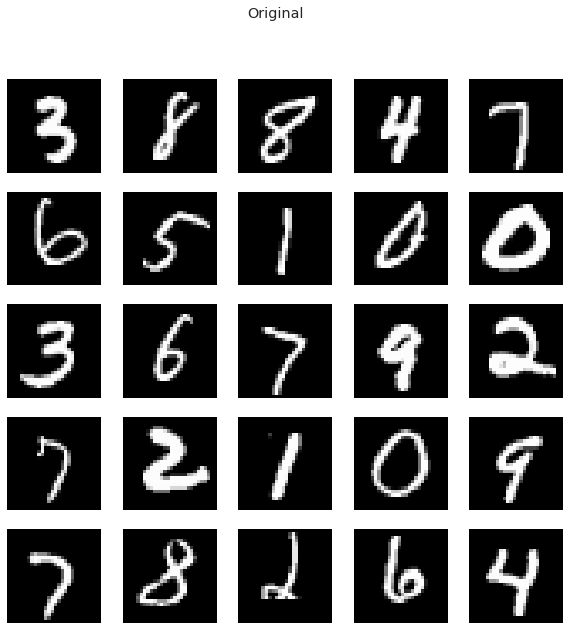

In [27]:

X_mnist_train_reduced = ush.transform(X_mnist_train, pca_mnist)
X_mnist_train_reduced.shape

# Show the original dataset
_= ush.mnh.visualize(X_mnist_train, y_mnist_train, title="Original")

Next, the reconstructed

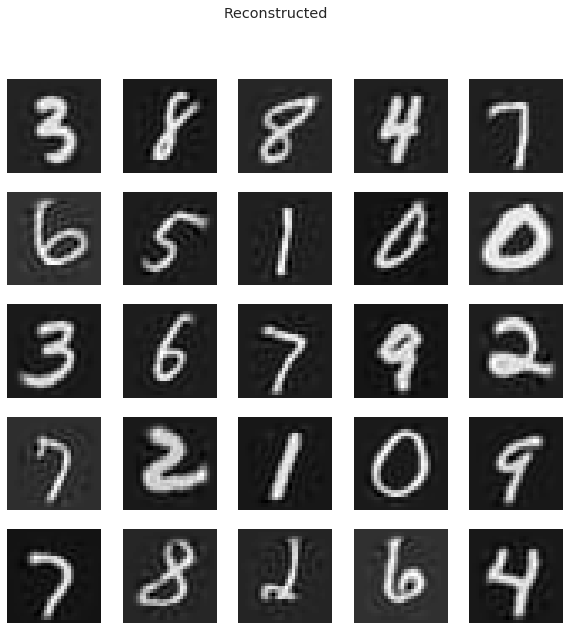

In [28]:
X_mnist_train_reconstruct = ush.inverse_transform(X_mnist_train_reduced, pca_mnist)
_= ush.mnh.visualize(X_mnist_train_reconstruct, y_mnist_train, title="Reconstructed")

A little fuzzy, but pretty good.


Do the 10 digits form natural clusters (all images of the same digit in the same cluster) ?

Let's look at the training images when reduced to
only 2 synthetic features.  



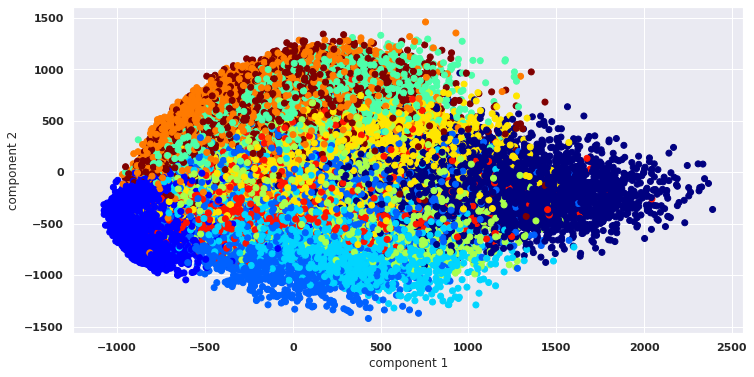

In [29]:
_ = ush.mnist_plot_2D(X_mnist_train_reduced, y_mnist_train.astype(int))

Each color is a different digit.

You can see that the clustering is far from perfect
- But also surprisingly good considering we're using only 2 out of 784 features

Let's see how much variance is captured by only the first two synthetic features.

In [30]:
cumvar_mnist = np.cumsum(pca_mnist.explained_variance_ratio_)
first_comp =2
cumvar_first = cumvar_mnist[first_comp-1]

print("Cumulative variance of {d:d} PC's is {p:.2f}%, about {n:.1f} pixels".format(
    d=first_comp, p=100 *cumvar_first, n=cumvar_first * X_mnist_train.shape[1]))


Cumulative variance of 2 PC's is 16.91%, about 132.6 pixels


Is 17% good ?  You bet !

With 784 original features (pixels)
- if each feature had equal importance, it would explain $1/784 = .12\%$ of the variance.  

So the first synthetic feature captures the variance of 132 original features 
- (assuming all were of equal importance).


<img src="images/Back_to_parent.jpg">

# PCA in Finance

## PCA of yield curve

[Litterman Scheinkman](https://www.math.nyu.edu/faculty/avellane/Litterman1991.pdf)

This is one of the most important papers (my opinion) in quantitative Fixed Income.

It allows us to hedge a large portfolio of bonds with a handful of instruments.


Before we show the result: why is this an important advance in Finance ?

- Imagine we had a large portfolio of Treasury bonds with many maturities.
- A common goal in Fixed Income Finance is to *immunize* (hedge) a portfolio to changes in the Yield Curve.
- The ideal hedge for a Treasury bond
    -is a bond with similar maturity date
    
But there are lots of maturity dates !

A more parsimonious way of hedging is to 
- define a small number $(n=14)$ of *benchmark* maturities
- for each bond in the portfolio
    - compute the sensitivity of the price of the bond
    - to a change in yield
    - for each benchmark
    
So each bond in the portfolio is represented as $n = 14$ features
- the sensitivity to each of the benchmark bonds

By summing up the sensitivities of all bonds in the portfolio
- we have a single vector of length $n = 14$)
- describing the total value of benchmark bonds
- that we need to *go short*
- in order to hedge our portfolio against changes in the yield curve

But even $(n = 14)$ hedging instruments is large
- transaction costs associated with each

The solution ?

PCA !
- replace $n = 14$ benchmark bonds
- with $r \lt n$ synthetic benchmarks

### Taking the PCA

We will obtain many examples of the Yield Curve.

Each example (daily yield curve)
- is a vector of $n = 14$ yields of the benchmarks, on a particular day

Here are a few examples
- sampled at a end-of-month

In [31]:
ych = unsupervised_helper.YieldCurve_PCA()

# Get the yield curve data
data_yc = ych.create_data()
data_yc.head()

,1M,2M,3M,6M,1J,2J,3J,4J,5J,6J,7J,8J,9J,10J
1992-02-29,0.0961,0.09610,0.0961,0.0958,0.0898,0.0864,0.0849,0.0837,0.0826,0.0817,0.0810,0.0806,0.0803,0.0804
1992-03-31,0.0970,0.09700,0.0970,0.0969,0.0912,0.0889,0.0877,0.0864,0.0852,0.0841,0.0833,0.0827,0.0823,0.0823
1992-04-30,0.0975,0.09750,0.0975,0.0975,0.0920,0.0892,0.0877,0.0862,0.0848,0.0837,0.0828,0.0822,0.0817,0.0816
1992-05-31,0.0978,0.09785,0.0979,0.0979,0.0920,0.0889,0.0874,0.0860,0.0847,0.0836,0.0828,0.0821,0.0817,0.0815
1992-06-30,0.0974,0.09745,0.0975,0.0975,0.0931,0.0904,0.0889,0.0874,0.0860,0.0848,0.0839,0.0832,0.0827,0.0825


In [32]:
data_yc.shape

(287, 14)

Each example (row) has 14 features
- the end-of-month Yield Curve
- the yields for 14 maturity points on a given date.

Let's plot the history of yield curves

/home/kjp/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


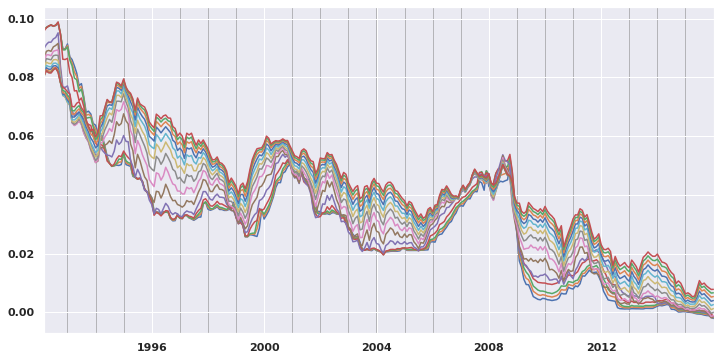

In [33]:
ych.plot_YC(data_yc)

In hedging
- we are concerned with **changes** in yield
- rather than the *level* of the yield
- we compute the sensitivity of a bond with respect to a *change in yield* of the hedging instrument

So we will perform PCA
- on **changes** in yield
- rather than the level of yield

of the 14 benchmarks.

Our goal is to reduce dimensionality from $n$ to $r \lt n$.

What value of $r$ is "good enough" ?

As usual
- we plot the cumulative variance
- as a function of the number of reduced dimensions
- choosing the $r$
- that meets a chosen threshold (e.g, 95%) of cumulative variance

Let's look at the plot.

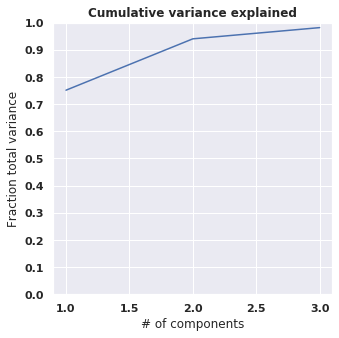

In [34]:
pca_yc, df_pca_yc = ych.doPCA(data_yc, doDiff=True)
_ = ych.plot_cum_variance(pca_yc)

Wow ! 

You'll notice that we don't display more than 3 dimensions
- that's because *almost 100 percent* of cumulative variance
- is captured by the first 3 components

So, we can hope to hedge
- with at most $3$ synthetic bonds

It gets even better !

By examining 
- the influence of each component
- on the $n = 14$ benchmark yield changes (original features)

we can *interpret* what the components represent 

For each component
- shock the component by 1 standard deviation
- compute the change (measured in standard deviations) of each of the $n=14$ yield changes (original features)

We plot a line for each component
- arranging benchmark maturities by increasing value as the horizontal axis
- Component 1: blue line
- Component 3: orangle line
- Component 3: green line




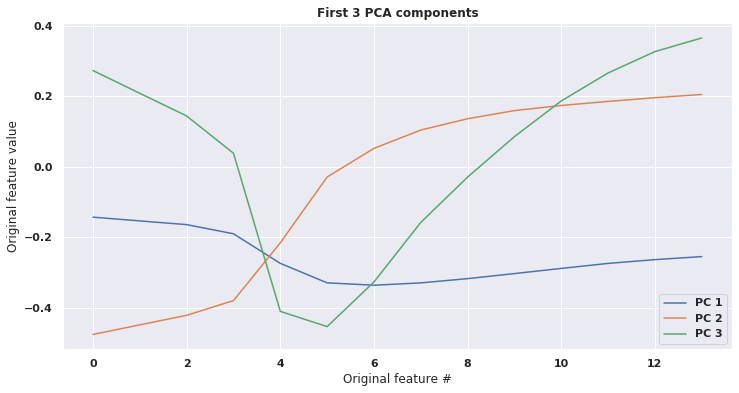

In [35]:
ych.plot_components(pca_yc)


A unit standard deviation value of synthetic  feature $j$ (PCj) 
- $(j=1)$: results in a roughly equal yield change across the $n = 14$ benchmarks
    - Corresponds to a parallel shift in the Yield Curve
- $(j=2)$: shows a dichotomy (of yield changes) between near and far maturities
    - Corresponds to the slope of the Yield Curve changing
- $(j=3)$: shows a dichotomy of yield changes of mid maturities versus extreme maturities
    - Corresponds to a twist in the Yield Curve about the 5 year maturity


This is a very typical pattern in Finance:
- The first synthetic feature affects all original features with roughly equal effect
- Higher synthetic features often express a *dichotomy*
    - Positive effect on some original features
    - Negative effect on other original features
    

### Aside

We are measuring changes in units of standard deviation.

Recall that
$$
\tilde\X = U \Sigma
$$

- $U$ are the *standardized* features (unit variance)
- that are scaled by diagonal matrix $\Sigma$ of variances

So we are graphing
- $U$ rather than $\tilde \X$

This also mean we can't compare the levels of the 3 separate curves
- since each component has a different standard deviation
$$\sigma_1 \gt \sigma_2 \gt \sigma_3$$

That is
- a unit standard deviation change in component $j$ 
- represents a large change
- than a unit standard deviation change in component $j' \gt j$


### Computing the effect on original features of change in synthetic feature

How do we obtain
- the effect of a small change in synthetic feature $\tilde\x_j$
- on each *original* feature $\x_{j'}, 1 \le j' \le n$

Recall
$$
\begin{array} \\
\X & = & \tilde\X \V^T & \text{definition} \\
  & = & U \Sigma \V^T & \text{since} \tilde\X = U \Sigma
\end{array} 
$$
where
$$
\begin{array} \\
\X: & (m \times n) \\
U: & (m \times r) \\
\Sigma: & (r \times r) \\
\V^T: & (r \times n)
\end{array}
$$

Consider example $i: \x^\ip_{j'}$

$$
\begin{array} \\
\x^\ip & = & U^\ip  \, \Sigma \, \V^T & \text{one row of the matrix multiplication} \\
\end{array}
$$

A one standard deviation increment in $\tilde\x_j$
- increases $U^\ip_j$ by $1$
- which results in an increase in $\x^\ip$ by
$$
\Delta \x^\ip(j)  =  \text{OHE}(j) \, \Sigma \, \V^T 
$$
where $\text{OHE}(j)$ is the OHE vector of length $n$ with element $j$ being non-zero
$$
\text{OHE}(j)_k ==
\begin{cases}
0 & k \ne j \\
1 & k = j
\end{cases}
$$

Observe that 
- $\Delta \x^\ip (j)$ is the same for *all* examples $i$

 Write as $\Delta \x(j)$ (no superscript).
 
- Left multiplication by $\text{OHE}(j)$ selects row $j$ of the right multiplicand
\begin{array} \\
\text{OHE}(j) * \Sigma =  \sigma_j *\text{OHE}(j) &  \text{OHE}(j) \text{ selects row } j \text{ of } \Sigma \\  
\end{array}
- Expanding $\Delta \x(j)$
$$
\begin{array} \\
\Delta \x(j) & = & \text{OHE}(j) \, \Sigma \, \V^T \\
& = & \sigma_j *\text{OHE}(j) \, \V^T & \text{since above shows } \text{OHE}(j) * \Sigma =  \sigma_j *\text{OHE}(j)\\
& = & \sigma_j * \V_j & \text{OHE}(j) \text{ selects row } j \text{ of } \V^T \\
& & & \text{equivalently: column } j \text{ of } \V \\
\end{array}
$$

Thus 
- $\Delta \x(j) = \sigma_j * \V_j$
- is the vector of length $n$
- such that element $j': 
\Delta \x(j)_{j'}
$
- is the effect on original feature $j'$ (independent of example)
- of a one standard deviation change in synthetic feature $j$

In other words
- $\V_j$ is the effect of a unit change in $\tilde \x_j$
- $\sigma_j * \V_j$ is the effect of a unit change in $\u_j$, where $\u$ is the standardized $\tilde \x$
    - equivalent to a one standard deviation change in $\tilde \x_j$

### Constructing the hedges (synthetic bonds)

The good news:
- we can construct a hedge portfolio using only 3 synthetic instruments (the components)
- and lose almost no information

The bad news:
- each synthetic bond (feature) is a linear combination of $n=14$ real bonds.
- although we have $r = 3$ synthetic components
- each is a vector length $n = 14$

So, in order to use fewer than $n = 14$ real bonds
- we will have to *approximate* the components
- using many fewer instruments

We
- choose one benchmark as our "proxy" for a parallel yield curve change
    - a very liquid maturity: 10 year
- construct a proxy for "slope change" using two benchmark bonds
    - long a long-maturity bond, short a short-maturity bond
    - both liquid: 2 year/30 year
- construct a proxy for the "butterfly change" using 3 benchmark bonds
    - long short and long-term maturities, short intermediate-maturity
    - 2 year/5 year/10 year butterfly

Using Linear Regression
- we can project the 14 benchmarks onto the 3 proxies

So rather than using *true* components (and true loadings on them)
- we use approximations
- that are consistent with our interpretation


### Finance details

This section has little to do with Machine Learning but quite a bit to do with Fixed Income Finance.

- We have captured changes in *yield* of a bond
- To hedge *price* changes (our goal) we still need to translate a yield change to a price change

- For bond $b$ with price $P_b$ and yield $y_b$ 
    - We need $\frac{\partial P_b}{\partial y_b}$
        - the change in Price of bond $b$ per unit change in its yield
    - This is known as the bond's *duration*
    - If we hold $\#_b$ units of bond $b$ in a Portfolio
        - the bond's contribution to portfolio price change is $\#_b$ times the above sensitivity
    - Sometimes more convenient to compute the *percent price* change per unit yield change
        - size of the hedge now in *number of dollars* rather than *number of bonds*
 

## PCA of the SP 500

The same analysis that we did for the Bond Universe works for other instruments.

Consider a universe of all stocks in a particular stock universe.

Recall our "factor model" of stock returns from our introduction

$$
\begin{array}[lll]\\
\X_1 = \beta_{1, \text{idx}}* \tilde\X_\text{index} + \beta_{1, \text{size}}* \tilde\X_\text{size} + \epsilon'_1 \\
\X_2 = \beta_{2, \text{idx}} * \tilde\X_\text{index} +  \beta_{2, \text{size}}* \tilde\X_\text{size} +\epsilon'_2 \\
\vdots \\
\X_{500} = \beta_{500, \text{idx}} * \tilde\X_\text{index} + \beta_{500, \text{size}}* \tilde\X_\text{size} ++ \epsilon'_{500} \\
\end{array}
$$

Using PCA
- we can discover common factors (i.e., the components)

The components are the common factors.

These are
- statistical artifacts
    - composed of the original large $n$ stocks
- rather than easy-to-interpret factors
    - Index, Size, Industry

But perhaps, like the PCA of the Yield Curve
- we can interpret the components
- as expressing economically meaningful factors

The interpretation of the components may change with time.

But one thing that is fairly constant
- the first ("most important") component
- is an almost equally weighted combination of all stocks in the universe
- the "parallel shift" factor
    - affecting all stocks
    - is an equally-weighted market index
    


The higher components vary much more.

But they often represent dichotomies.

Some common themes (hypotheses for you to investigate in trying to interpret them)
- Economic cycle
    - cyclical versus non-Cyclical stocks
- Size
    - Large versus small cap stocks
- Industry
    - in one particular industry versus not in that industry

Interpretation is not easy
- not as simple as the "labels"
- require economic intuition

## Interpreting the PC's

We have previously illustrated several tools to interpret the components.

One way was via clustering
- hypothesize a common property of a cluster
- interpret the components by how
    - a change in component 
    - changes the common property
        - e.g., moving from "open curve (3)" to "closed curve (8)"
        

Another way
- hypothesize the common property among a subset of examples
- examine the loadings of each example on the various components

That is how, in the $(8 \times 8)$ pixel grid of digits
- we can to interpret the first component
- as the concept of being $0$

For PCA of the Yield Curve
- we *implicitly* hypothesized that the components
- could affect subsets of maturities differently

We were able to visualize the subsets by plotting
- sensitivity of original feature
- to unit change in component


But this plotting *only worked*
- because we (luckily) chose to arrange the horizontal access by maturity
- the subsets depended on the *relative order* of maturities
    - e.g., Components 2: long versus short
    
Had the subsets been defined differently
- the plots would not been revealing

Suggestion
- come up with an hypothesis
- arrange your examples along the horizontal access according to the intensity of an example on this hypothesis
    - e.g., arrange all Cyclical stocks before all Non-Cyclical stocks
    - e.g., arrange all Tech stocks before all Non-Tech stocks
- vertical axis
    - how much the *original* feature (e.g., return of the stock)
    - is affected by a unit change in the component
    

If your hypothesis is true
- similar examples, with similar sensitivities to the compoment
- will appear adjacent to one another
- rather than randomly scattered

<img src="images/Back_to_parent.jpg">

In [36]:
print("Done")

Done
